# Code generated by Gemini

This is an executable colab that follows [this AI studio example]().

First, install Qualtran

In [1]:
!pip install -q git+https://github.com/quantumlib/Qualtran

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Quantum For-Loop

In [2]:
import numpy as np
import cirq
import qualtran.testing as qlt_testing
from qualtran import BloqBuilder
from qualtran.bloqs.multiplexers.apply_lth_bloq import ApplyLthBloq
from qualtran.cirq_interop import CirqGateAsBloq
from qualtran.drawing import show_bloq

# Parameters for the coherent for-loop
L = 4  # Number of unitaries to select from.
target_bitsize = 2  # Number of qubits in the target register.
selection_bitsize = (L - 1).bit_length()

# --- Create L random Pauli operators for V_i ---
pauli_strings = []
rng = np.random.default_rng(seed=42)
print("Defining the V_i operations:")
for i in range(L):
    # Create a random Pauli string of length `target_bitsize`
    pauli_string = ''.join(rng.choice(['I', 'X', 'Y', 'Z'], size=target_bitsize))
    pauli_strings.append(cirq.DensePauliString(pauli_string))
    print(f"  V_{i} = {pauli_strings[-1]}")

# Wrap the Cirq gates in `CirqGateAsBloq` to use them in Qualtran.
V_i_bloqs = [CirqGateAsBloq(cirq.DensePauliString(p)) for p in pauli_strings]

Defining the V_i operations:
  V_0 = +IZ
  V_1 = +YX
  V_2 = +XZ
  V_3 = +IY



High-level SELECT operation:


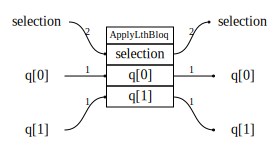

In [3]:
# This bloq implements the coherent for-loop: U = sum |i><i| tensor V_i
select_op = ApplyLthBloq(np.array(V_i_bloqs))

# Visualize the high-level operation.
# The 'selection' register takes an index `i`, and the corresponding `V_i`
# is applied to the 'q' (target) register.
print("\nHigh-level SELECT operation:")
show_bloq(select_op)


Decomposition showing the Unary Iteration implementation:


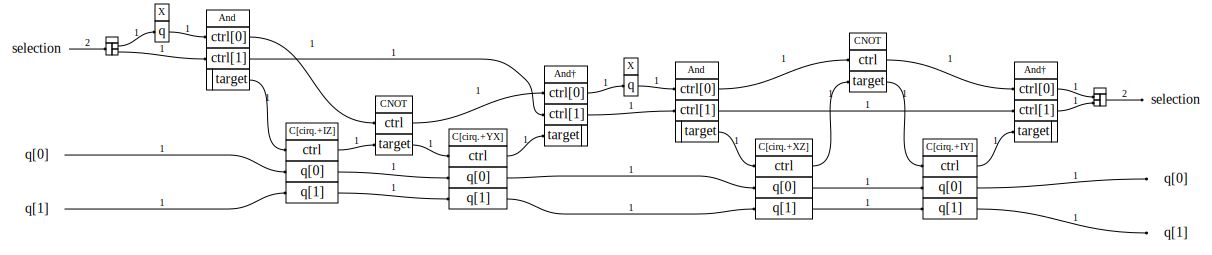

In [4]:
# Show how the coherent for-loop is implemented using a ladder of `And` gates
# which control the application of each V_i.
print("\nDecomposition showing the Unary Iteration implementation:")
show_bloq(select_op.decompose_bloq())

In [5]:
# Get the full unitary matrix of the SELECT operation
select_unitary = select_op.tensor_contract()

# Verify that for each selection index `l`, the correct V_l is applied.
print("\nVerifying the operation...")
for l in range(L):
    # Extract the sub-matrix corresponding to the selection index `l`
    start = l * (2**target_bitsize)
    end = (l + 1) * (2**target_bitsize)
    v_l_from_select = select_unitary[start:end, start:end]

    # Get the expected unitary for V_l
    v_l_expected = cirq.unitary(pauli_strings[l])

    # Check that they are the same
    assert np.allclose(v_l_from_select, v_l_expected)
    print(f"  Selection index l={l}: V_{l} applied correctly. Verified.")

print("\nVerification successful!")


Verifying the operation...
  Selection index l=0: V_0 applied correctly. Verified.
  Selection index l=1: V_1 applied correctly. Verified.
  Selection index l=2: V_2 applied correctly. Verified.
  Selection index l=3: V_3 applied correctly. Verified.

Verification successful!


## Nested For-Loops

In [6]:
import numpy as np
import cirq
import qualtran.testing as qlt_testing
from qualtran import BloqBuilder
from qualtran.bloqs.multiplexers.apply_lth_bloq import ApplyLthBloq
from qualtran.cirq_interop import CirqGateAsBloq
from qualtran.drawing import show_bloq

# Parameters for the nested coherent for-loop
M = 2  # Iteration length of the outer loop (i)
L = 4  # Iteration length of the inner loop (j)
target_bitsize = 2  # Number of qubits in the target register.

# --- Create a 2D array of M x L random Pauli operators for V_ij ---
V_ij_bloqs = np.empty((M, L), dtype=object)
V_ij_paulis = np.empty((M, L), dtype=object)

rng = np.random.default_rng(seed=101)
print("Defining the V_ij operations:")
for i in range(M):
    for j in range(L):
        # Create a random Pauli string of length `target_bitsize`
        pauli_string = ''.join(rng.choice(['I', 'X', 'Y', 'Z'], size=target_bitsize))
        V_ij_paulis[i, j] = cirq.DensePauliString(pauli_string)
        V_ij_bloqs[i, j] = CirqGateAsBloq(V_ij_paulis[i, j])
        print(f"  V_{i},{j} = {V_ij_paulis[i, j]}")

Defining the V_ij operations:
  V_0,0 = +XZ
  V_0,1 = +YX
  V_0,2 = +IZ
  V_0,3 = +XY
  V_1,0 = +YX
  V_1,1 = +XZ
  V_1,2 = +ZZ
  V_1,3 = +IX



High-level SELECT operation for nested loops:


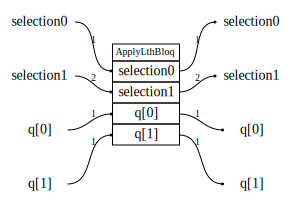

In [7]:
# This bloq implements the nested coherent for-loop:
# U = sum_{i,j} |i>|j><i|<j| tensor V_ij
select_op_nested = ApplyLthBloq(V_ij_bloqs)

# Visualize the high-level operation.
# Note the two selection registers: `selection_0` and `selection_1`.
print("\nHigh-level SELECT operation for nested loops:")
show_bloq(select_op_nested)


Decomposition of the nested SELECT operation:


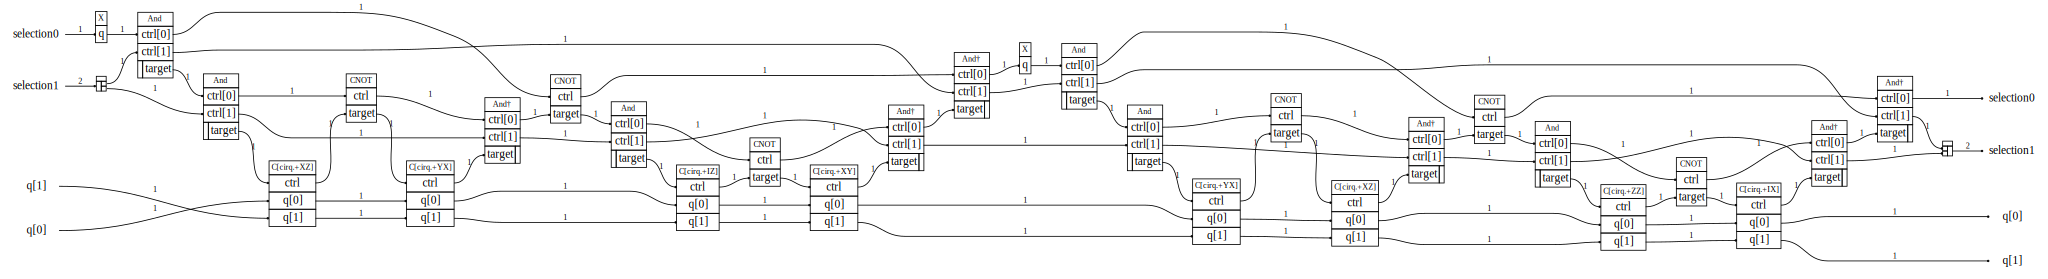

In [8]:
print("\nDecomposition of the nested SELECT operation:")
show_bloq(select_op_nested.decompose_bloq())

In [9]:
# Get the full unitary matrix of the nested SELECT operation
select_unitary_nested = select_op_nested.tensor_contract()
target_dim = 2**target_bitsize

print(f"\nVerifying the {M}x{L} operation...")
for i in range(M):
    for j in range(L):
        # Calculate the flattened index for the (i, j) pair
        flat_idx = i * L + j

        # Extract the sub-matrix corresponding to the selection index |i>|j>
        start = flat_idx * target_dim
        end = (flat_idx + 1) * target_dim
        V_ij_from_select = select_unitary_nested[start:end, start:end]

        # Get the expected unitary for V_ij
        V_ij_expected = cirq.unitary(V_ij_paulis[i, j])

        # Check that they are the same
        assert np.allclose(V_ij_from_select, V_ij_expected)
        print(f"  Selection index i={i}, j={j}: V_{i},{j} applied correctly. Verified.")

print("\nVerification successful!")


Verifying the 2x4 operation...
  Selection index i=0, j=0: V_0,0 applied correctly. Verified.
  Selection index i=0, j=1: V_0,1 applied correctly. Verified.
  Selection index i=0, j=2: V_0,2 applied correctly. Verified.
  Selection index i=0, j=3: V_0,3 applied correctly. Verified.
  Selection index i=1, j=0: V_1,0 applied correctly. Verified.
  Selection index i=1, j=1: V_1,1 applied correctly. Verified.
  Selection index i=1, j=2: V_1,2 applied correctly. Verified.
  Selection index i=1, j=3: V_1,3 applied correctly. Verified.

Verification successful!


## Hamming weight phasing

In [10]:
import numpy as np
import qualtran.testing as qlt_testing
from qualtran.bloqs.rotations import HammingWeightPhasing
from qualtran.drawing import show_bloq

# Parameters for the Hamming Weight Phasing operation
bitsize = 4
# We will apply a Z**0.25 rotation to each qubit.
# This is equivalent to applying a T gate to each qubit in the |1> state.
exponent = 0.25

High-level view of HammingWeightPhasing for 4 qubits:


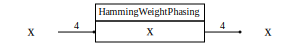

In [11]:
# Instantiate the bloq.
hwp_op = HammingWeightPhasing(bitsize=bitsize, exponent=exponent)

# Visualize the high-level operation.
print(f"High-level view of HammingWeightPhasing for {bitsize} qubits:")
show_bloq(hwp_op)


Decomposition showing the compute-phase-uncompute structure:


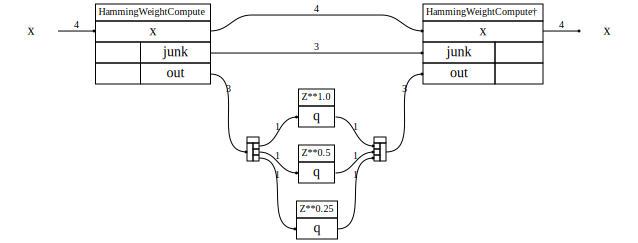

In [12]:
print("\nDecomposition showing the compute-phase-uncompute structure:")
show_bloq(hwp_op.decompose_bloq())

In [13]:
# Get the full unitary matrix of the operation.
U = hwp_op.tensor_contract()

print("\nVerifying the phasing for each basis state:")
verification_passed = True
for i in range(2**bitsize):
    # Calculate the Hamming Weight of the current basis state index `i`
    binary_string = bin(i)[2:]
    hw = binary_string.count('1')

    # Calculate the expected phase factor
    expected_phase = np.exp(1j * np.pi * exponent * hw)

    # Get the actual phase from the unitary
    actual_phase = U[i, i]

    # Compare them
    if not np.allclose(actual_phase, expected_phase):
        verification_passed = False
        print(f"  State |{i:0{bitsize}b}> (HW={hw}): FAILED!")
        print(f"    - Actual phase:   {np.round(actual_phase, 4)}")
        print(f"    - Expected phase: {np.round(expected_phase, 4)}")
    else:
        print(f"  State |{i:0{bitsize}b}> (HW={hw}): Passed.")


print("\nVerification successful!" if verification_passed else "\nVerification FAILED.")


Verifying the phasing for each basis state:
  State |0000> (HW=0): Passed.
  State |0001> (HW=1): Passed.
  State |0010> (HW=1): Passed.
  State |0011> (HW=2): Passed.
  State |0100> (HW=1): Passed.
  State |0101> (HW=2): Passed.
  State |0110> (HW=2): Passed.
  State |0111> (HW=3): Passed.
  State |1000> (HW=1): Passed.
  State |1001> (HW=2): Passed.
  State |1010> (HW=2): Passed.
  State |1011> (HW=3): Passed.
  State |1100> (HW=2): Passed.
  State |1101> (HW=3): Passed.
  State |1110> (HW=3): Passed.
  State |1111> (HW=4): Passed.

Verification successful!
